In [8]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

# Cities listings

This dataset correspond to the rooms surounding the target rooms that appear on the Non-Personalized ranking that Airbnb generates for anonimous users.

## General overview

In [1]:
%matplotlib inline
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
# Set some Pandas options
pd.set_option('display.notebook_repr_html', False);
pd.set_option('display.max_columns', 20);
pd.set_option('display.max_rows', 25);
#Setting path to read Chicago Datasets

path ='/home/raul/recsys_airbnb/'
city_labels = ["NYC", "SFO", "LAX", "CHI", "BOS"]
dataset = pd.read_csv(path+'datasets/cities.csv', sep="\t", header=0,na_values="NaNxxxx",low_memory=False);
dataset.city = dataset.id.str[0:3]
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

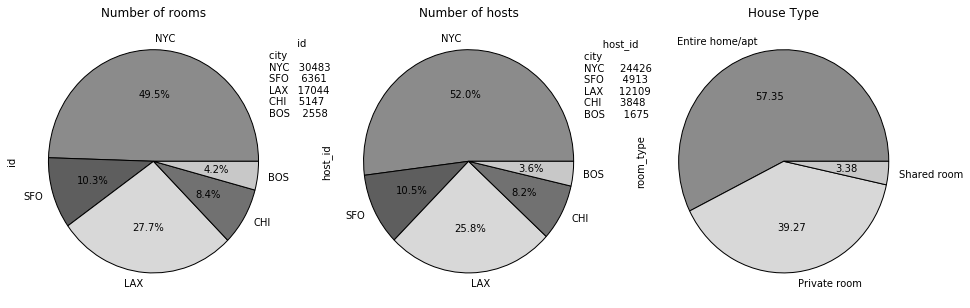

In [10]:
from IPython.display import HTML

fig, axs = plt.subplots(1,3)

number_of_rooms_by_city = pd.DataFrame( dataset.groupby("city").id.unique().apply(len) )
number_of_rooms_by_city.id.loc[city_labels].plot(kind="pie", 
    colormap=grayify_cmap("prism"), figsize=(6,5), autopct='%1.1f%%', ax=axs[0],
    title="Number of rooms").text(1.1,0.4,str(number_of_rooms_by_city.loc[city_labels]))

number_of_host_by_city = pd.DataFrame( dataset.groupby("city").host_id.unique().apply(len) )
number_of_host_by_city.host_id.loc[city_labels].plot(kind="pie", ax = axs[1],
    colormap=grayify_cmap("prism"), figsize=(6,5), autopct='%1.1f%%',
    title="Number of hosts").text(1.1,0.4,str(number_of_host_by_city.loc[city_labels]))

labels = [ "Entire home/apt", "Private room", "Shared room"]
room_type = dataset["room_type"].value_counts()
room_type.plot(kind="pie", labels=labels, colormap=grayify_cmap("prism"),  autopct="%.2f", 
               fontsize=10, figsize=(3, 3), title="House Type", ax = axs[2]);

fig.set_size_inches(16, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Number of reviews

In [11]:
fig, axs = plt.subplots(3,2)
i_plot = 0
f = "number_of_reviews"
for city in city_labels:   
    data = dataset[dataset.city == city]
    sturges = lambda n: int(np.log2(n) + 1)
    square_root = lambda n: int(np.sqrt(n))
    from scipy.stats import kurtosis
    doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))
    n = len(data[f])
    #We calculate the optimal number of bins
    sturges(n), square_root(n), doanes(data[f].dropna())
    g= data[f].hist(bins=50,color="k", ax=axs[int(i_plot/2)][int(i_plot%2)]);
    g.set_xlabel("Number of reviews");
    g.set_ylabel("Normalized Frequency");
    g.set_title(city+" # of reviews");
    i_plot+=1
fig.set_size_inches(18, 10)
fig.tight_layout()
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Pricing

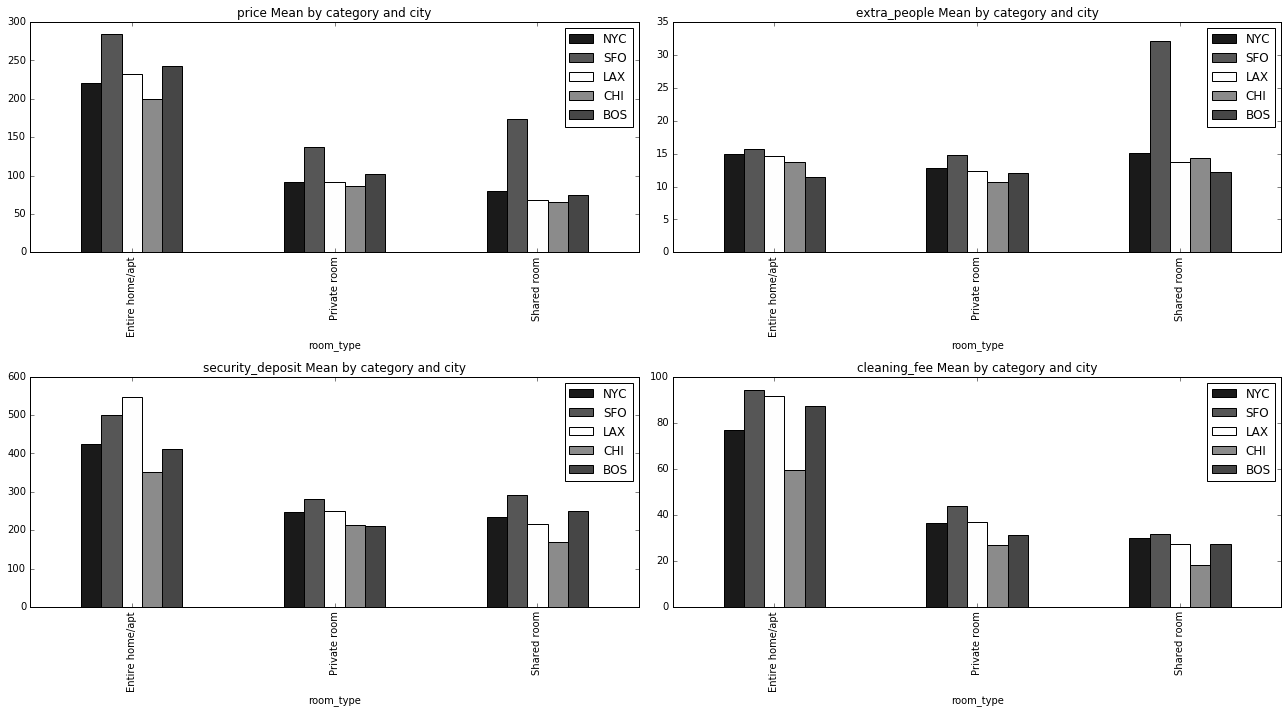

In [12]:
fig, axs = plt.subplots(2,2)
i_plot = 0
features=["price","extra_people", "security_deposit","cleaning_fee"]
for f in features:
    city = dataset[dataset.city=="NYC"]
    price_mean_by_city_by_room_type = city.groupby("room_type")[f].mean()
    for c in city_labels[1:]:
        #c = city_labels[2]
        city = dataset[dataset.city==c]
        price_mean_by_city_by_room_type_local = city .groupby("room_type")[f].mean()
        price_mean_by_city_by_room_type = pd.concat([price_mean_by_city_by_room_type
                , price_mean_by_city_by_room_type_local], axis=1)

    price_mean_by_city_by_room_type.columns = city_labels
    price_mean_by_city_by_room_type.plot(kind="bar",figsize=(10,5), colormap=grayify_cmap("seismic")
        , title=f+" Mean by category and city", ax=axs[int(i_plot/2)][i_plot%2]);
    i_plot+=1

HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')
fig.set_size_inches(18, 10)
fig.tight_layout()
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Pricing by capacity and number of rooms

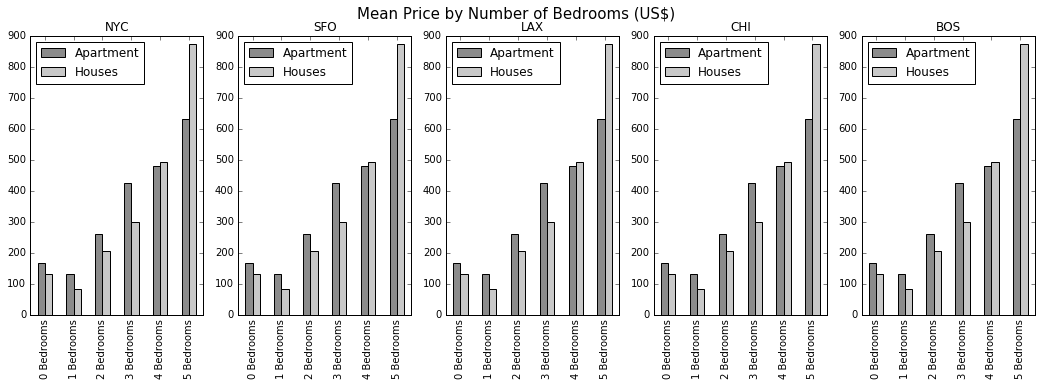

In [13]:
fig, axs = plt.subplots(1,5)
fig2, axs2 = plt.subplots(1,5)
i_plot = 0

for c in city_labels:
    city = dataset[dataset.city=="NYC"]
    houses_by_bedrooms = city[city["property_type"] == "House"].groupby("bedrooms")
    apartment_by_bedrooms = city[city["property_type"] == "Apartment"].groupby("bedrooms")
    house_apartment_by_bedrooms = pd.DataFrame({"Houses":houses_by_bedrooms["price"].mean()[0:5].values,
    "Apartment":apartment_by_bedrooms["price"].mean()[0:5].values})
    house_apartment_by_bedrooms.index = ["0 Bedrooms","1 Bedrooms","2 Bedrooms","3 Bedrooms","4 Bedrooms","5 Bedrooms"]
    house_apartment_by_bedrooms.plot(kind="bar", colormap=grayify_cmap("prism")
        ,title=c, ax=axs[i_plot]);

    houses_by_accommodates = city[city["property_type"] == "House"].groupby("accommodates")
    apartment_by_accommodates = city[city["property_type"] == "Apartment"].groupby("accommodates")
    house_apartment_by_accommodates = pd.DataFrame({"Houses":houses_by_accommodates["price"].mean()[0:5].values,
    "Apartment":apartment_by_accommodates["price"].mean()[0:5].values})
    temp_label = ["0 accommodates","1 accommodates","2 accommodates","3 accommodates","4 accommodates"]
    house_apartment_by_accommodates.index = temp_label
    house_apartment_by_accommodates.plot(kind="bar", colormap=grayify_cmap("prism")
        ,title=c, ax=axs2[i_plot]);
    i_plot+=1
fig.set_size_inches(18, 5)
fig.suptitle("Mean Price by Number of Bedrooms (US$)", fontsize=15)

fig2.set_size_inches(18, 4)
fig2.suptitle("Mean Price by Number of People It Accommodates (US$)", fontsize=15)

HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

### Property Amenities

In [8]:
proposed_f=["confortness","expensiveness",'price_mean','price_std','price_centered_mu',
            'price_centered_mean','price_normalized','context_skew','context_kurtosis']
context_f = ["context_mean","context_min", "context_max", "context_histogram", 
             "context_number_of_rooms","context_names", "context_prices", "context_ratings", 
             "context_number_of_reviews", "context_room_type", "context_room_id", "context_host_id", 
             "context_instant_booking", "context_super_hosts"]
categorical_f = ["property_type","room_type", "bed_type"]
ordinal_f = ["host_response_time"]
space_f = ["accommodates", "bathrooms", "bedrooms", "beds"]
booking_f = ["minimum_nights", "host_acceptance_rate", "host_response_rate","guests_included", "check_out", "check_in"]
price_f = ["price", "weekly_price", "monthly_price", "security_deposit","cleaning_fee", "extra_people"]
rating_f = ["number_of_reviews","review_scores_rating","review_scores_accuracy","review_scores_cleanliness", 
            "review_scores_checkin", "review_scores_communication", 
            "review_scores_location", "review_scores_value"]
text_f = ["summary", "space", "description", "experiences_offered", 
          "neighborhood_overview", "notes", "transit"]
local_f = ["street","neighbourhood", "city"'state','zipcode','market'
           ,'smart_location','country_code','country',
           'latitude','longitude']
language_f = ["language"]

no_used_f = ["host_since","host_location","host_about","host_is_superhost","host_verifications",
             "cancellation_policy","instant_bookable","reviews_per_month"            
             ,"id","listing_url","scrape_id","thumbnail",'last_scraped', 'name'
             ,'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url','host_id'
             , 'host_url', 'host_name', 'host_thumbnail_url','host_picture_url'
             , 'host_neighbourhood', 'host_listings_count','host_total_listings_count'
             , 'host_has_profile_pic','host_identity_verified', 'neighbourhood_cleansed'
             ,'neighbourhood_group_cleansed', 'city', 'state','is_location_exact'
             , 'amenities', 'square_feet', 'calendar_updated','has_availability', 'availability_30'
             , 'availability_60','availability_90', 'availability_365', 'calendar_last_scraped','first_review'
             , 'last_review', 'requires_license', 'license','jurisdiction_names', 'require_guest_profile_picture'
             ,'require_guest_phone_verification','calculated_host_listings_count', 'maximum_nights']

property_type_f = list(dataset.property_type.str.strip().str.replace(" ", "_").unique())
room_type_f = list(dataset.room_type.str.strip().str.replace(" ", "_").unique())
bed_type_f = list(dataset.bed_type.str.strip().str.replace(" ", "_").unique())

no_dummy_f = no_used_f+categorical_f+ordinal_f+space_f+booking_f+price_f+rating_f+text_f+local_f
no_dummy_f = no_dummy_f+language_f+property_type_f +room_type_f+bed_type_f+context_f+proposed_f
no_dummy_f = no_dummy_f+["bed_type_NaN","room_type_NaN","property_type_NaN"]

no_dummy_f = dataset.columns[dataset.columns.isin(no_dummy_f)].unique()
amenities_f= dataset.columns[~dataset.columns.isin(no_dummy_f)].tolist()


amenities = dataset[amenities_f].apply(pd.Series.value_counts).T
#print(amenities)
#amenities[1] = amenities[1] + amenities[2].fillna(0)
#amenities = amenities[[0,1]]
amenities = amenities.fillna(0)
amenities.columns=["Not Include", "Include"]
amenities_counting = amenities[["Include", "Not Include"]].sort_values("Include", ascending=False)
amenities_counting.plot(kind="bar", title="", stacked=True, figsize=(20,5), colormap=grayify_cmap("prism"));
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')


## Space Features (Accomodates, Bathrooms, Bedrooms and Beds)

In [9]:
features = ["accommodates", "bathrooms", "bedrooms", "beds"]
data = pd.DataFrame( dataset[features].dropna() )
data.boxplot(return_type="axes",figsize=(6,6));

HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

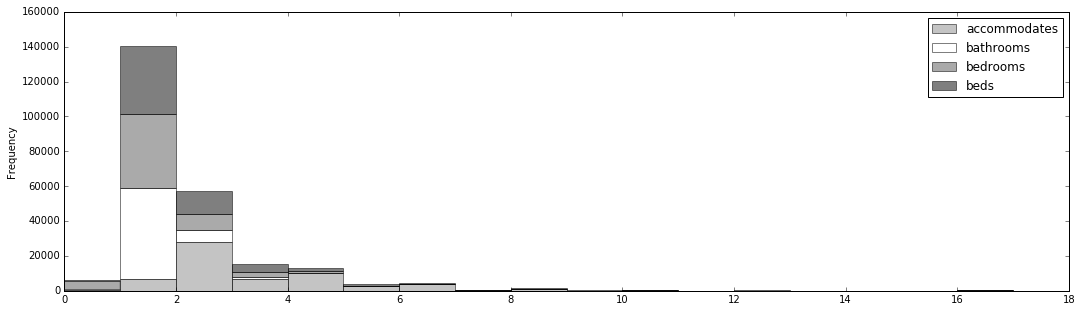

In [10]:
data.plot.hist(stacked=True, bins=18, alpha=0.5, colormap=grayify_cmap("flag"), figsize=(18,5));

##  Property Type

In [21]:
fig, axs = plt.subplots(5,1)
i_plot=0
for c in city_labels:
    data = dataset[dataset.city == c]
    feature = "property_type"
    data[feature] = data[feature].replace("+ More","Unavailable")
    ax = data[feature].value_counts().plot(kind="barh", color="k" ,figsize=(18, 20)
               ,title=feature+" "+c, ax=axs[i_plot])
    for p in ax.patches:
        ax.annotate(str( int(p.get_width()) ), ( p.get_width() * 1.005, p.get_y() * 1.005))
    i_plot+=1  
fig.set_size_inches(200, 200)
fig.suptitle("Property Type by City", fontsize=15)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Fees
Each room has a **dayly-based price**, which we simply refer to it as: **price**. Complementary, hosts may also include a **weekly price** and **monthly price** according to the length of stays. Similarly, hosts are allow to specify **extra people** fee in case where they allow guests to exeed the regular accomodation capacity. Finally,hosts may charge an unique **security deposit** and **cleaning fee** if applicable.

The following graphs aim to scout fee features:

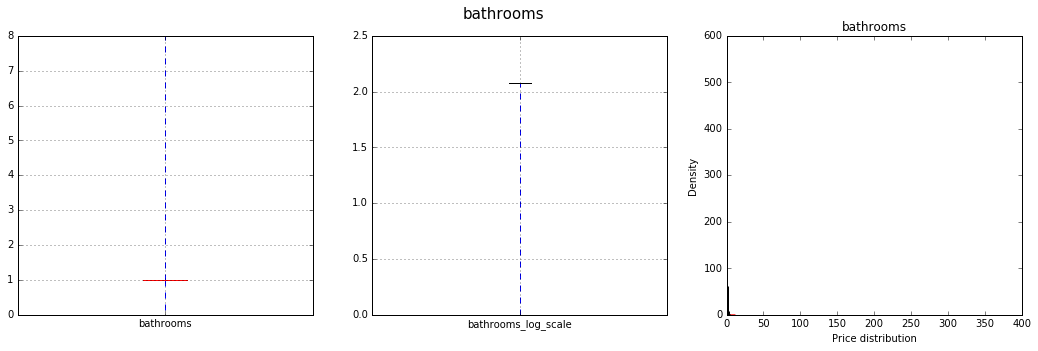

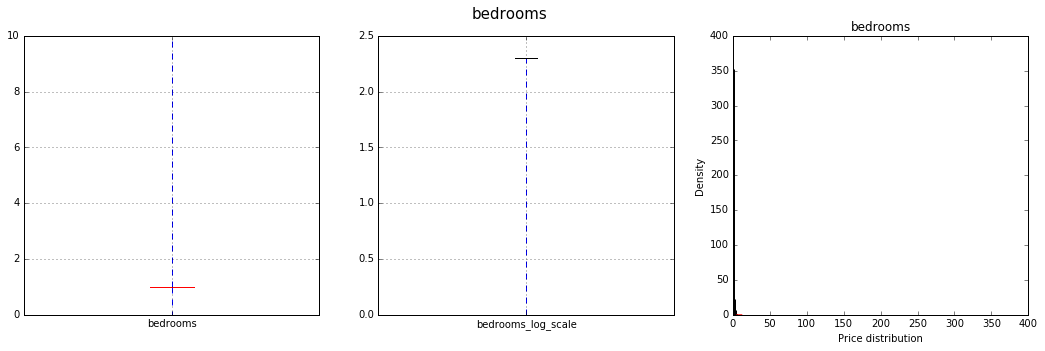

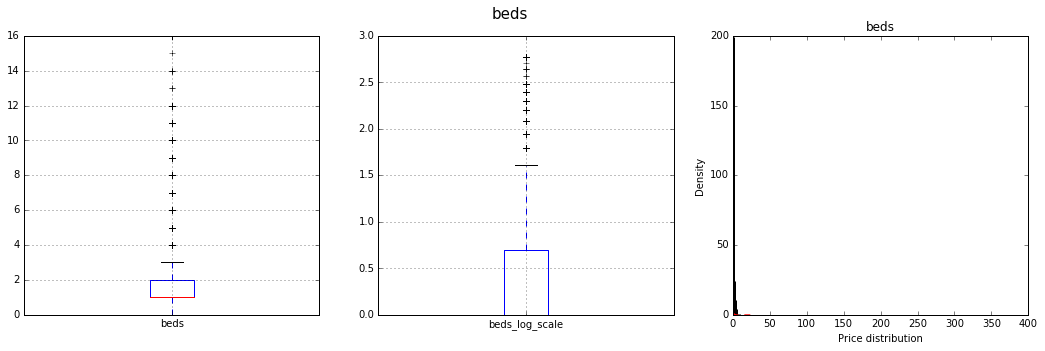

In [14]:
from scipy.stats import kurtosis

for f in features:
    fig, axs = plt.subplots(1,3)
    data = pd.DataFrame( dataset[f].dropna())
    g =data.boxplot(return_type="axes", figsize=(6,6), ax=axs[0])
    
    data = pd.DataFrame( np.log(dataset[f].dropna()))
    data.columns = [f+"_log_scale"]
    g = data.boxplot(return_type="axes", figsize=(6,6), ax=axs[1])

    #We calculate the optimal number of bins
    data = dataset
    features = ["price", "weekly_price", "monthly_price"]
    sturges = lambda n: int(np.log2(n) + 1)
    square_root = lambda n: int(np.sqrt(n))
    doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))
    n = len(data[f])
    sturges(n), square_root(n), doanes(data[f].dropna())

    g= data[f].hist(bins=5000, normed=True, color="k" , ax=axs[2])
    g.set_xlabel("Price distribution");
    g.set_title(f);
    data[f].dropna().plot(kind="kde", xlim=(0,400), style="r--", ax=axs[2])

    fig.set_size_inches(18, 5)
    fig.suptitle(f, fontsize=15)
    
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Fees correlations
The following charts show only rooms where hosts set values to all prices (daily, weekly and monthly) and
cleaning and extra fees.

In [ ]:
from pandas.tools.plotting import scatter_matrix

data = dataset
features = ["price", "weekly_price", "monthly_price", "extra_people", "security_deposit","cleaning_fee"]
scatter_matrix(data[features].dropna(), alpha=0.2, figsize=(9, 9), diagonal="kde", color="k");

HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Ratings


In [ ]:
fig, axs = plt.subplots(1,1)
data = dataset.review_scores_rating[dataset.review_scores_rating > 0]
g = data.hist(color="k", bins=100,figsize=(10, 4));
g.set_xlabel("Rating Score");
g.set_ylabel("Frequency");
fig.set_size_inches(15, 4)

fig, axs = plt.subplots(3,2)
features = ["review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
            "review_scores_communication","review_scores_location","review_scores_value"]
k=0
for x in [0,1,2]:
    for y in [0,1]:
        f = features[k]
        data = dataset[dataset[f]>0]
        data[f].hist(color="k", bins=50, ax=axs[x,y]);
        axs[x,y].set_title(f);
        k = k+1
fig.set_size_inches(15, 8)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

In [ ]:
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()